In [ ]:
!nvidia-smi

Sun Apr 18 20:30:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    30W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
import matplotlib.pyplot as plt
import os
import random
import sklearn
import numpy as np
from tqdm.notebook import tqdm
from PIL import Image
from glob import glob
import csv
import zipfile

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
zip_file_path = '/content/drive/MyDrive/SKI/First_task/train.zip'

z = zipfile.ZipFile(zip_file_path, 'r')
z.extractall()

filename_list = os.listdir('train')
filename_list = sorted(filename_list, key=lambda v:int(v.split('/')[-1][:-4]))

images = []

for img_filename in tqdm(filename_list):
    # print(img_filename)
    img_path = ('train' + '/' + img_filename)
    img = np.asarray(Image.open(img_path))
    images.append(img)



In [ ]:
labels = []

csv_path = '/content/drive/MyDrive/SKI/First_task/train_tags.csv'
with open(csv_path, "r") as file_obj:
    reader = csv.reader(file_obj)
    for row in reader:
        if row[1] == 'sunglasses':
            labels.append(1)
        if row[1] == 'open':
            labels.append(0)
# print(labels)

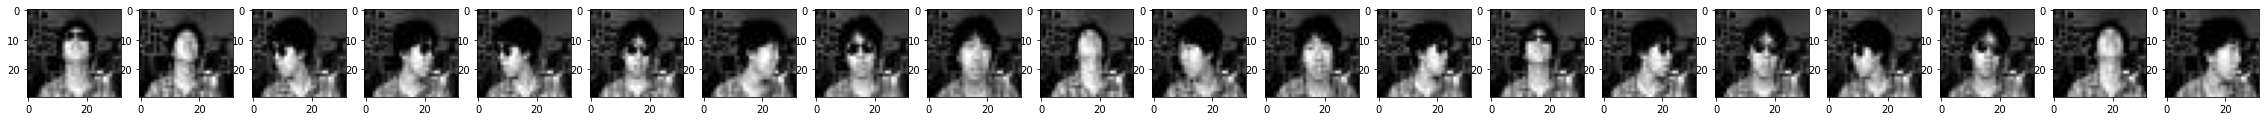

In [ ]:
def print_images(images_for_print):
    figure = plt.figure(figsize=(40, 40))
    for i in range(len(images_for_print)):
        ax = figure.add_subplot(1, len(images_for_print), i + 1)
        ax.imshow(images_for_print[i], cmap = 'gray')    
print_images(images[0:20])   

# **Data augmentation**

In [ ]:
X = []
Y = []
for i in range(len(images)):
    if labels[i]:
        X.append(images[i])
    else:
        Y.append(images[i])
X = (X - np.min(X)) / (np.max(X) - np.min(X) + 1e-8)
Y = (Y - np.min(Y)) / (np.max(Y) - np.min(Y) + 1e-8)
images_with_glasses = X
images_open = Y

In [ ]:
from torchvision import transforms

RESIZE = transforms.Resize((32, 32))
data_augmentation = torch.nn.Sequential(
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20))

In [ ]:
new_images_with_glasses = []
for first_image in tqdm(images_with_glasses):
    image = RESIZE(torch.tensor(first_image).unsqueeze(0))
    new_images_with_glasses.append(image[0].detach().numpy())
    for i in range(3):
        augmented_image = data_augmentation(image)[0].detach().numpy()
        new_images_with_glasses.append(augmented_image)

new_images_open = []
for first_image in tqdm(images_open):
    image = RESIZE(torch.tensor(first_image).unsqueeze(0))
    new_images_open.append(image[0].detach().numpy())
    for i in range(3):
        augmented_image = data_augmentation(image)[0].detach().numpy()
        new_images_open.append(augmented_image)

In [ ]:
all_augmented_images = []
all_labels = []

for i in range(len(new_images_with_glasses)):
    all_augmented_images.append(new_images_with_glasses[i])
    all_labels.append(1)
    all_augmented_images.append(new_images_open[i])
    all_labels.append(0)
    
len(all_augmented_images)

1512

In [ ]:
all_augmented_images = torch.tensor(all_augmented_images).unsqueeze(1)
all_labels = torch.tensor(all_labels)

# **Make Dataset and Dataloader**

In [ ]:
validation_size = 200

In [ ]:
from torch.utils.data import  DataLoader, TensorDataset
def data_loaders(x, y):
    x_train = x[0:len(x) - validation_size].clone()
    y_train = y[0:len(y) - validation_size].clone()
    x_valid = x[len(x) - validation_size: len(x)].clone()
    y_valid = y[len(y) - validation_size: len(y)].clone()
    dataset_train = TensorDataset(x_train, y_train)
    dataset_valid = TensorDataset(x_valid, y_valid)

    loader_train = DataLoader(
        dataset_train,
        batch_size=20,
        shuffle=True,
    )
    loader_valid = DataLoader(
        dataset_valid,
        batch_size=20,
        drop_last=True,
    )

    return loader_train, loader_valid

In [ ]:
loader_train, loader_valid = data_loaders(all_augmented_images, all_labels)


#**C_Net**

In [ ]:
class C_Net(torch.nn.Module):
    def __init__(self, in_channels = 1, num_classes = 1):
        super(C_Net, self).__init__()

        self.bn0 = torch.nn.BatchNorm2d(num_features=1)

        self.conv1 = torch.nn.Conv2d(in_channels, out_channels=16, kernel_size=3, padding=1)
        self.act1 = torch.nn.ReLU()
        self.bn1 = torch.nn.BatchNorm2d(num_features=16)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.act2 = torch.nn.ReLU()
        self.bn2 = torch.nn.BatchNorm2d(num_features=32)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.act3 = torch.nn.ReLU()
        self.bn3 = torch.nn.BatchNorm2d(num_features=64)
        
        self.fc1 = torch.nn.Linear(8 * 8 * 64, 256)
        self.act4 = torch.nn.ReLU()
        self.bn4 = torch.nn.BatchNorm1d(num_features=256)

        self.fc2 = torch.nn.Linear(256, 64)
        self.act5 = torch.nn.ReLU()
        self.bn5 = torch.nn.BatchNorm1d(num_features=64)

        self.fc3 = torch.nn.Linear(64, num_classes)
        self.act6 = torch.nn.Sigmoid()
    
    def forward(self, x):
        x = self.bn0(x)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.pool1(x)     

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.pool2(x) 
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.act3(x)
         
        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x  = self.bn4(x)
        x = self.act4(x)

        x = self.fc2(x)    
        x  = self.bn5(x)
        x = self.act5(x)

        x = self.fc3(x)
        x = self.act6(x)
        x = x.view(-1)
        return x

In [ ]:
model = C_Net(1,1)
print(model(torch.randn(10, 1, 32, 32)).shape)
assert tuple(model(torch.randn(10, 1, 32, 32)).shape) == (10,)
print("Success!")


torch.Size([10])
Success!


# **ResNet**

In [ ]:
import torch.nn as nn

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.act1 = nn.ReLU()
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.act2 = nn.ReLU()

    def forward(self, x):
        out = self.bn1(self.conv1(x))
        out = self.act1(out)
        out = self.bn2(self.conv2(out))
        out = self.act2(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1):
        super(ResNet, self).__init__()

        self.in_planes = 16

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.act = nn.ReLU()

        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)

        self.pool1 = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(64, num_classes)
        self.act2 = nn.Sigmoid()

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.bn1(self.conv1(x))
        out = self.act(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.pool1(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        out = self.act2(out)
        out = out.view(-1)
        
        return out


def resnet20():
    return ResNet(BasicBlock, [3, 3, 3])


In [ ]:
model = resnet20()
p = model(torch.randn(10, 1, 32, 32))
print(p.shape)
assert tuple(model(torch.randn(10, 1, 32, 32)).shape) == (10,)
print("Success!")


torch.Size([10])
Success!


In [ ]:
accuracies = {}
losses = {}

In [ ]:
def train(model, 
          lr,
          weight_decay,
          max_epoch,
          loader_train, 
          loader_valid):
    device = torch.device('cuda:0' 
                      if torch.cuda.is_available() 
                      else 'cpu')
    

    criterion = torch.nn.BCEWithLogitsLoss()
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr= lr, weight_decay=weight_decay)
    test_accuracy_history = []
    test_loss_history = [] 

    for epoch in range(max_epoch):

        for x_train, y_test in tqdm(loader_train):
            model.train()
            torch.cuda.empty_cache()
            
            x_train = x_train.to(device = 'cuda', dtype=torch.float)
            y_test = y_test.to(device = 'cuda', dtype=torch.float)

            optimizer.zero_grad()
            preds = model(x_train)
            # print(preds)
            loss = criterion(preds, y_test)
            loss.backward()
            optimizer.step()
        accuracy = 0
        test_loss = 0
        n = 0
        for X_test, y_test in loader_valid:
            X_test = X_test.to(device = 'cuda', dtype=torch.float)
            y_test = y_test.to(device = 'cuda', dtype=torch.float)
            model.eval()
            test_preds = model(X_test)
            accuracy += ((test_preds>=0.5) == (y_test==1)).float().mean().cpu()
            test_loss += criterion(test_preds, y_test).cpu()
            n += 1
        test_loss_history.append(test_loss/n)
        print(accuracy/n)
        test_accuracy_history.append(accuracy/n)
        if (epoch > max_epoch//2) and (test_loss_history[epoch]-test_loss_history[epoch-1] > 0.2):
            break
    # torch.save(model.state_dict(), '/content/drive/MyDrive/SKI/First_task/ResNet/ResNet15.pt')
    # del model
    return model, test_accuracy_history, test_loss_history


Learning_rate = 0.001
Weight_decay = 0.00001
Epoch = 9

Model, accuracies['ResNet:lr=0.001, wd=0.00001'], losses['ResNet:lr=0.001, wd=0.00001'] = \
    train(resnet20(), Learning_rate, Weight_decay, Epoch, loader_train, loader_valid)
Model1, accuracies['ResNet:lr=0.0001, wd=0.00001'], losses['ResNet:lr=0.0001, wd=0.00001'] = \
    train(resnet20(), 0.0001, 0.00001, 19, loader_train, loader_valid)

# Model, accuracies['C_Net:lr=0.001, wd=0.0001'], losses['C_Net:lr=0.001, wd=0.0001'] = \
#     train(C_Net(1,1), 0.001, 0.0001, 15, loader_train, loader_valid)
# Model1, accuracies['C_Net:lr=0.0001, wd=0.00001'], losses['C_Net:lr=0.0001, wd=0.00001'] = \
#     train(C_Net(1,1),  0.0001, 0.00001, 30, loader_train, loader_valid)


tensor(0.5000)



tensor(0.5600)



tensor(0.9100)



tensor(0.8500)



tensor(0.8900)



tensor(0.6950)



tensor(0.9050)



tensor(0.7250)



tensor(0.9100)



tensor(0.5250)



tensor(0.6450)



tensor(0.7350)



tensor(0.7550)



tensor(0.7850)



tensor(0.7650)



tensor(0.7550)



tensor(0.7800)



tensor(0.7650)



tensor(0.8150)



tensor(0.7950)



tensor(0.7700)



tensor(0.8250)



tensor(0.7350)



tensor(0.8100)



tensor(0.7500)



tensor(0.7700)



tensor(0.7700)



tensor(0.8550)


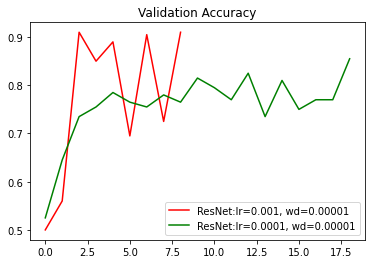

In [ ]:
colors = ['Red', 'Green']
i = 0
for experiment_id in accuracies.keys():
    plt.plot(accuracies[experiment_id], label=experiment_id, color=colors[i])
    i += 1
plt.legend()
plt.title('Validation Accuracy');

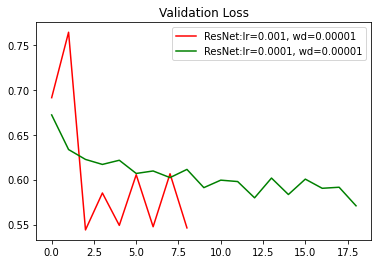

In [ ]:
colors = ['Red', 'Green']
i = 0
for experiment_id in losses.keys():
    plt.plot(losses[experiment_id], label=experiment_id, color=colors[i])
    i += 1
plt.legend()
plt.title('Validation Loss');

In [ ]:
# torch.save(Model.state_dict(), '/content/drive/MyDrive/SKI/First_task/ResNet/ResNet_.pt')

# **Test model**

In [ ]:
zip_file_path = '/content/drive/MyDrive/SKI/First_task/test.zip'

z = zipfile.ZipFile(zip_file_path, 'r')
z.extractall()

test_filename_list = os.listdir('test')
test_filename_list = sorted(test_filename_list, key=lambda v:int(v.split('/')[-1][:-4]))

test_images = []

for img_filename in tqdm(test_filename_list):
    # print(img_filename)
    img_path = ('test' + '/' + img_filename)
    img = np.asarray(Image.open(img_path))
    test_images.append(img)



In [ ]:
test_images = (test_images - np.min(test_images)) / (np.max(test_images) - np.min(test_images) + 1e-8)

test_tensor = torch.tensor(test_images).clone()
from torchvision import transforms
RESIZE = transforms.Resize((32, 32))
test_tensor = RESIZE(test_tensor)

In [ ]:
len(test_tensor)

22140

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
dataloader = DataLoader(
    dataset = test_tensor,
    batch_size = 20,
    shuffle = False)
test_model = resnet20().cuda()
# test_model.load_state_dict(torch.load('/content/drive/MyDrive/SKI/First_task/ResNet/ResNet_94.pt'))
test_model = Model

In [ ]:
ans = []

for item in tqdm(dataloader):
    item = item.unsqueeze(1).to(device = 'cuda', dtype=torch.float)
    test_model.eval()
    pred = test_model(item)
    y = pred.to('cpu')
    # print(pred)
    ans.extend(y.detach().numpy())
    torch.cuda.empty_cache()
# ans = torch.tensor(ans)

In [ ]:
with open('/content/drive/MyDrive/SKI/First_task/Dmitriy_Novikov.csv', 'w') as csvfile:
    csvwriter=csv.writer(csvfile)
    csvwriter.writerow(['id', 'sunglasses_probability'])
    for i in range(len(ans)):
        csvwriter.writerow([i, round(ans[i], 5)])